In [227]:
import os, json
from functools import reduce
import numpy as np
import pandas as pd
from scipy.io import loadmat
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from Bio.KEGG import REST

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut,cross_val_predict, LeaveOneGroupOut, KFold

from dGbyG.utils.ChemFunc import parse_equation
from dGbyG.utils.custom_tools import rapid_process_result, rapid_linear_reg
from dGbyG.config import train_data_path

EC number mapping module

In [223]:
tecrdb = pd.read_csv('../data/experimental_dG_from_eQ/TECRDB.csv').loc[:,['description', 'reaction', 'EC']]
tecrdb = tecrdb.drop_duplicates().reset_index(drop=True)
data={'COCOM00001':'C80015',
'COCOM00002':'C80019',
'COCOM00003':'C80020',
'COCOM00004':'C80021',
'COCOM00005':'C80023',
'COCOM00006':'C80026',
'COCOM00007':'C80028',
'COCOM00008': 'C80029',
'COCOM00009': 'C80030',
'COCOM00010':'C80052',
'COCOM00011':'C80055',
'COCOM00012': 'C80057',
'COCOM00013': 'C80058',
'metanetx.chemical:MNXM39260':'C80069'
}
small_mol = {'C00001':'Water', 'C00011':'CO2', 'C00080':'H+', 'C00288':'HCO3-'}

def classify_by_ec(ec_startswith, ec_list):
    children, not_children = [], []
    for EC in ec_list:
        if pd.isna(EC):
            children.append(False), not_children.append(False)
            continue

        EC = [EC]
        remove_ec, add_ec = set(), set()
        for ec in EC:
            if '&' in ec:
                remove_ec.add(ec)
                add_ec |= set(ec.split('&'))
        EC = (set(EC) | add_ec) - set(remove_ec)

        child, not_child = True, True
        for ec in EC:
            if not ec.startswith(ec_startswith):
                child = False
            else:
                not_child = False
        children.append(child), not_children.append(not_child)
    return np.array(children), np.array(not_children)

def kegg_get(dbentry, query):
    try:
        m = REST.kegg_get(dbentries=dbentry).read().split('\n')
    except:
        return False
    R = []
    for l in m:
        if l.startswith(query):
            R = l.split()[1:]
        elif R and l.startswith(' '):
            R = R+l.split()
        elif R and not l.startswith(' '):
            return R
    return R

def conv(c):
    if c.startswith('kegg:'):
        return c[5:].strip()
    elif c.startswith('COCO:'):
        return data.get(c[5:])
    elif c.startswith('metanetx.chemical:'):
        return data.get(c)
    else:
        print(c)
        return c

Cross validation module

CC (eQuilibrator) and Search ec number for reactions

In [269]:
# cc method model (linear regression model)
def linreg_K_fold_cv_predict(X, y, K):
    py = np.full_like(y, fill_value=np.nan)
    for i, (train_index, test_index) in enumerate(KFold(K).split(X,y)):
        x = np.linalg.lstsq(X[train_index],y[train_index], rcond=None)
        py[test_index] = X[test_index] @ x[0]
    assert ~np.isnan(py).any()
    return py

def linreg_validation_predict(X, y, train_bool, val_bool):
    w = np.linalg.pinv(X[train_bool].T@X[train_bool]) @ X[train_bool].T @ y[train_bool]
    py = X[val_bool] @ w
    return py

In [245]:
ac = loadmat('../../dGPredictor/data/component_contribution_python.mat')

df_S = pd.DataFrame(ac['train_S'])
df_S_unique = df_S.T.drop_duplicates().T
unque_cols = df_S_unique.columns.values.tolist()
S = ac['train_S']
S = S[:, unque_cols]

b_list = json.load(open('../../dGPredictor/data/median_b.json'))
b = np.asarray(b_list).reshape(-1,1)

G = ac['G']

assert G.shape[0] == S.shape[0]
assert b.shape == (S.shape[1], 1)

cids = ac['train_cids']
reactions = [dict(zip(cids[s!=0], s[s!=0])) for s in S.T]

ec_num = []
for r in reactions:
    if len(r)==1:
        ec_num.append(np.nan)
        continue
    n = None
    for Rawr, ec in zip(tecrdb.loc[:,'reaction'], tecrdb.loc[:,'EC']):
        Rawr = parse_equation(Rawr)
        Rawr = dict([(conv(c),v) for c,v in Rawr.items()])
        if (set(Rawr)-set(small_mol))==(set(r)-set(small_mol)):
            n = ec
            break
    ec_num.append(n)
ec_num = np.array(ec_num)

idxs = np.where(ec_num==None)[0]
for i in idxs:
    reactants = set(reactions[i])-set(small_mol)
    reaction = [kegg_get(entry, 'REACTION') for entry in reactants]
    reaction = [x for x in reaction if x]
    reaction = Counter(reduce(lambda x, y:x+y, reaction) if reaction else [])
    reaction_set = reaction.most_common((Counter(reaction.values()).get(max(reaction.values())))) if reaction else reaction
    reaction_set = [x for x,_ in reaction_set]
    print(i, reactions[i], b[i], reaction_set)

21 {'C00005': 1.0, 'C00006': -1.0, 'C00493': -1.0, 'C02652': 1.0} [55.61052009] ['R02413']
666 {'C00003': -1.0, 'C00004': 1.0} [21.8156897] ['R00023', 'R00090', 'R00091', 'R00092', 'R00093', 'R00094', 'R00095', 'R00100', 'R00101', 'R00112', 'R00143', 'R00145', 'R00203', 'R00209', 'R00214', 'R00215', 'R00228', 'R00243', 'R00245', 'R00286', 'R00300', 'R00342', 'R00365', 'R00368', 'R00384', 'R00396', 'R00398', 'R00402', 'R00421', 'R00445', 'R00446', 'R00501', 'R00519', 'R00538', 'R00562', 'R00581', 'R00604', 'R00605', 'R00623', 'R00624', 'R00631', 'R00675', 'R00688', 'R00700', 'R00703', 'R00704', 'R00705', 'R00707', 'R00709', 'R00710', 'R00713', 'R00715', 'R00717', 'R00732', 'R00754', 'R00758', 'R00787', 'R00794', 'R00812', 'R00813', 'R00818', 'R00823', 'R00842', 'R00868', 'R00875', 'R00880', 'R00892', 'R00904', 'R00906', 'R00922', 'R00935', 'R00936', 'R00937', 'R00977', 'R00994', 'R01000', 'R01033', 'R01034', 'R01036', 'R01061', 'R01088', 'R01093', 'R01094', 'R01130', 'R01142', 'R01158',

In [246]:
ec_num[21] = '1.1.1.25'

Cross validation

In [247]:
X = np.dot(S.T,G)
y = b

# cross validation
print('LOOCV')
loocv_y = linreg_K_fold_cv_predict(X, y, y.shape[0])
print('median of cv is: ', np.median(np.abs(loocv_y-y)))
print('mean of cv is: ', np.mean(np.abs(loocv_y-y))), print()

K = 10
print('{0}-fold CV'.format(K))
cv_10_y = linreg_K_fold_cv_predict(X, y, K)
print('median of cv is: ', np.median(np.abs(cv_10_y-y)))
print('mean of cv is: ', np.mean(np.abs(cv_10_y-y))), print()

K = 5
print('{0}-fold CV'.format(K))
cv_5_y = linreg_K_fold_cv_predict(X, y, K)
print('median of cv is: ', np.median(np.abs(cv_5_y-y)))
print('mean of cv is: ', np.mean(np.abs(cv_5_y-y))), print()

K = 2
print('{0}-fold CV'.format(K))
cv_2_y = linreg_K_fold_cv_predict(X, y, K)
print('median of cv is: ', np.median(np.abs(cv_2_y-y)))
print('mean of cv is: ', np.mean(np.abs(cv_2_y-y)))

LOOCV
median of cv is:  5.325898869058361
mean of cv is:  19.455854675660053

10-fold CV
median of cv is:  6.270516806643411
mean of cv is:  23.333111761967725

5-fold CV
median of cv is:  7.351619440920452
mean of cv is:  30.921670575871033

2-fold CV
median of cv is:  12.142538804616866
mean of cv is:  209.5198178183361


In [248]:
# cross validation (split by ec class)
formation_dG_bool = np.asarray([sum(s!=0)==1 for s in S.T])
ec_cv_result = []
for x in range(1,7):
    children, not_children = classify_by_ec(str(x), ec_num)
    train_bool = not_children | formation_dG_bool
    val_bool = children
    total_bool = train_bool | val_bool
    
    cy = np.full_like(y, fill_value=np.nan)
    cy[val_bool] = linreg_validation_predict(X,y, train_bool, val_bool)
    ec_cv_result.append(cy)

In [249]:
ec_cv_y = np.nanmean(ec_cv_result, axis=0)
print('median of cv is: ', np.nanmedian(np.abs(ec_cv_y-y)))
print('mean of cv is: ', np.nanmean(np.abs(ec_cv_y-y)))

median of cv is:  10.739754230147902
mean of cv is:  35.509990772321096


/tmp/ipykernel_3888926/2653617699.py:1: RuntimeWarning: Mean of empty slice
  ec_cv_y = np.nanmean(ec_cv_result, axis=0)


The linear model is: Y = 15.932 + 1.4278X
PearsonRResult(statistic=0.3492000134825354, pvalue=6.402871514757927e-14)
SignificanceResult(statistic=0.8158866108766205, pvalue=4.5186424876071545e-105)


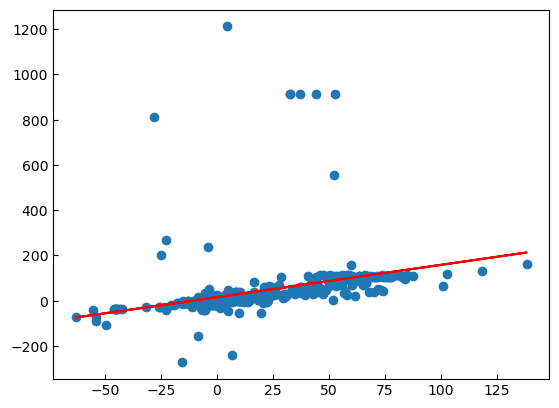

In [250]:
_ = rapid_linear_reg(y, ec_cv_y, plot=True)

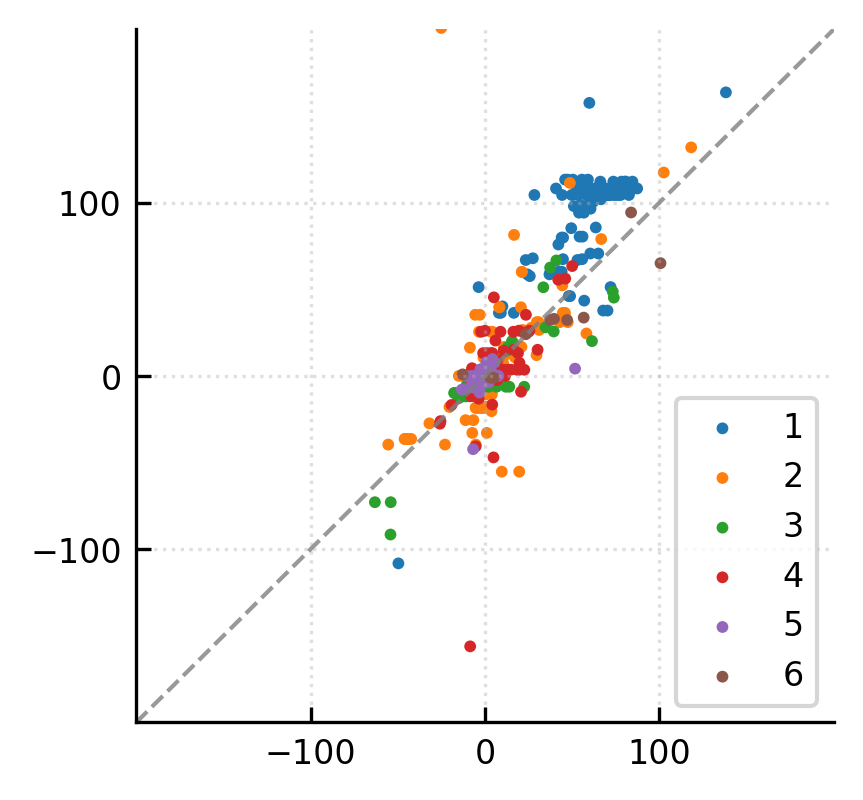

In [251]:
plt.figure(dpi=300,figsize = (3,3))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
ax=plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_position(('data', 0))
#ax.spines['bottom'].set_position(('data', 0))
#ax.xaxis.set_ticks_position('top')
#ax.xaxis.set_label_position('top')
ax.set_xlabel

plt.grid(alpha=0.4, linestyle=':')
for x in range(1,7):
    children, not_children = classify_by_ec(str(x), ec_num)
    plt.scatter(y[children], ec_cv_y[children], alpha=1, s=8, edgecolors='none')

plt.xticks([-100,0,100], fontsize=8)
plt.yticks([-100,0,100], fontsize=8)
plt.legend(list(range(1,7)), fontsize=8, loc='lower right')

plt.plot([-200,200], [-200,200], linewidth=1, linestyle='--', color='gray', alpha=0.8)

plt.xlim(-200,200)
plt.ylim(-200,200)
plt.show()

AF (dGPredictor)

In [270]:
# AF mothod model (ridge regression model)
def ridge_K_fold_cv_predict(X, y, alpha, K):
    py = np.full_like(y, fill_value=np.nan)
    for i, (train_index, val_index) in enumerate(KFold(K).split(X,y)):
        py[val_index] = ridge_validation_predict(X, y, alpha, train_index, val_index)
    assert ~np.isnan(py).any()
    return py

def ridge_validation_predict(X, y, alpha, train_bool, val_bool):
    w = np.linalg.inv(X[train_bool].T@X[train_bool]+alpha*np.eye(X.shape[1])) @ X[train_bool].T @ y[train_bool]
    py = X[val_bool] @ w
    return py

In [275]:
# read data
r1_d = loadmat('../../dGPredictor/data/dGPredictor_stereo.mat')
r2_d = loadmat('../../dGPredictor/data/radius2_mat_data_modified_manual.mat')

Gr1 = r1_d['G']
Gr2 = r2_d['G_inc_r2_compar']

df_S = pd.DataFrame(r1_d['train_S'])
df_S_unique = df_S.T.drop_duplicates().T
unque_cols = df_S_unique.columns.values.tolist()
S = r1_d['train_S']
S = S[:, unque_cols]

b_list = json.load(open('../../dGPredictor/data/median_b_manual_correction_r2.json')) # it will be same for both radius, it just remove all the repeated data points from the training data
b = np.asarray(b_list).reshape(-1,1)

X1 = np.dot(S.T, Gr1)
X2 = np.dot(S.T, Gr2)

XX = np.concatenate((X1, X2), axis =1)
yy = b.flatten()

alphas = np.logspace(-6, 6, 200)
regr = RidgeCV(alphas=alphas,fit_intercept= False).fit(XX, yy)
regr_cv = Ridge(alpha=regr.alpha_,fit_intercept=False)

In [276]:
# cross validation combined moiety model
print('LOOCV')
cy = cross_val_predict(regr_cv, XX, yy, cv=LeaveOneOut())
print('median of cv is: ', np.median(np.abs(cy-yy)))
print('mean of cv is: ', np.mean(np.abs(cy-yy))), print()

K = 10
print('{0}-fold CV'.format(K))
cy = cross_val_predict(regr_cv, XX, yy, cv=K)
print('median of cv is: ', np.median(np.abs(cy-yy)))
print('mean of cv is: ', np.mean(np.abs(cy-yy))), print()

K = 5
print('{0}-fold CV'.format(K))
cy = cross_val_predict(regr_cv, XX, yy, cv=K)
print('median of cv is: ', np.median(np.abs(cy-yy)))
print('mean of cv is: ', np.mean(np.abs(cy-yy))), print()

K = 2
print('{0}-fold CV'.format(K))
cy = cross_val_predict(regr_cv, XX, yy, cv=K)
print('median of cv is: ', np.median(np.abs(cy-yy)))
print('mean of cv is: ', np.mean(np.abs(cy-yy)))

LOOCV
median of cv is:  5.484989593132767
mean of cv is:  16.256106507029905

10-fold CV
median of cv is:  6.863716043596881
mean of cv is:  21.03983242828879

5-fold CV
median of cv is:  7.436390988011028
mean of cv is:  23.418372933048776

2-fold CV
median of cv is:  16.291783604761306
mean of cv is:  201.7818612552281


In [294]:
# cross validation (split by ec class)
formation_dG_bool = np.asarray([sum(s!=0)==1 for s in S.T])
ec_cv_result = []
for x in range(1,7):
    children, not_children = classify_by_ec(str(x), ec_num)
    train_bool = not_children | formation_dG_bool
    val_bool = children
    total_bool = train_bool | val_bool
    ec_group = np.zeros(shape=len(ec_num))
    ec_group[val_bool] = 1
    ec_group[train_bool] = 2
    cy = np.full_like(yy, fill_value=np.nan)
    cy[total_bool] = cross_val_predict(regr_cv, XX[total_bool], yy[total_bool], groups=ec_group[total_bool], cv=LeaveOneGroupOut())
    cy[train_bool] = np.nan
    ec_cv_result.append(cy)

In [292]:
ec_cv_y = np.nanmean(ec_cv_result, axis=0)
print('median of cv is: ', np.nanmedian(np.abs(ec_cv_y-yy)))
print('mean of cv is: ', np.nanmean(np.abs(ec_cv_y-yy)))

median of cv is:  13.873279308527334
mean of cv is:  43.20811063455773


/tmp/ipykernel_3888926/2075335275.py:1: RuntimeWarning: Mean of empty slice
  ec_cv_y = np.nanmean(ec_cv_result, axis=0)


The linear model is: Y = -5.487 + -0.030051X
PearsonRResult(statistic=-0.016195526180435252, pvalue=0.7362415569855028)
SignificanceResult(statistic=-0.05459830933618281, pvalue=0.2558271890725723)


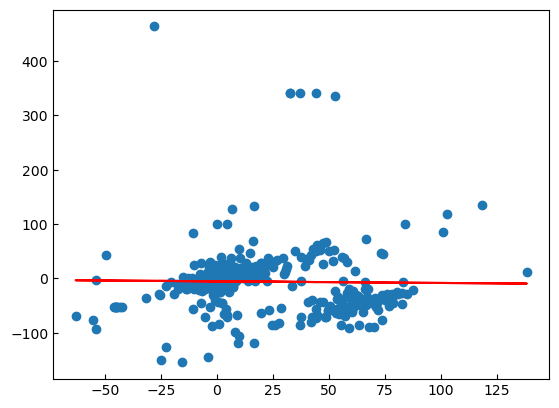

In [293]:
_ = rapid_linear_reg(yy, ec_cv_y, plot=True)

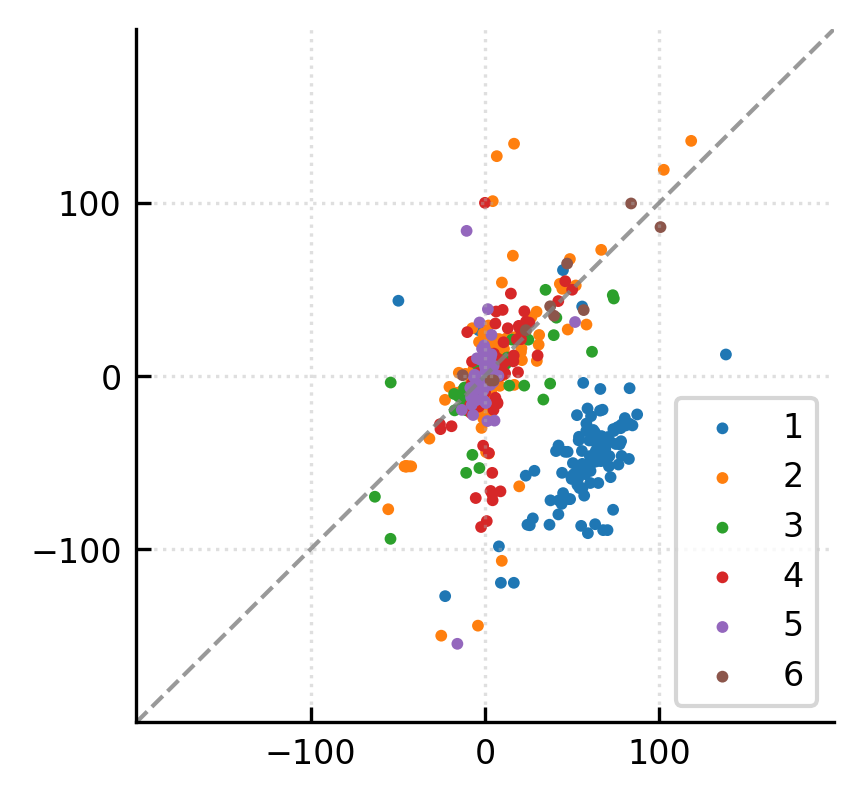

In [288]:
plt.figure(dpi=300,figsize = (3,3))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
ax=plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_position(('data', 0))
#ax.spines['bottom'].set_position(('data', 0))
#ax.xaxis.set_ticks_position('top')
#ax.xaxis.set_label_position('top')
ax.set_xlabel

plt.grid(alpha=0.4, linestyle=':')
for x in range(1,7):
    children, not_children = classify_by_ec(str(x), ec_num)
    plt.scatter(yy[children], ec_cv_y[children], alpha=1, s=8, edgecolors='none')

plt.xticks([-100,0,100], fontsize=8)
plt.yticks([-100,0,100], fontsize=8)
plt.legend(list(range(1,7)), fontsize=8, loc='lower right')

plt.plot([-200,200], [-200,200], linewidth=1, linestyle='--', color='gray', alpha=0.8)

plt.xlim(-200,200)
plt.ylim(-200,200)
plt.show()